In [1]:
#hack till I make it a real package..
import os
import sys
sys.path.append("../../")

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,6,7'
import jax 
jax.config.update('jax_disable_jit', False)


In [2]:
import diffhydro as dh
from diffhydro.utils.io import athinput,athdf


In [3]:
#from diffhydro.utils.parallel import halo_helper


In [4]:
#halo_helper.halo_pad_1d

In [5]:
#change to your sim location!
athena_outputs_loc = "/home/ben.horowitz/DiffHydro/tests/athena_ref_outputs/kh-slip/"

ic_filename = "kh-slip.out2.00000.athdf"

ICs = athdf(athena_outputs_loc+ic_filename)


In [6]:
#manually map from athena file to my format

import jax.numpy as jnp
sol = jnp.zeros((5,128,256))

sol = sol.at[0].set(ICs["dens"][0])
sol = sol.at[1].set(ICs["mom2"][0])
sol = sol.at[2].set(ICs["mom1"][0])
sol = sol.at[3].set(ICs["mom3"][0])
sol = sol.at[-1].set(ICs["Etot"][0])

In [7]:
sol = sol[:,:,:,jnp.newaxis]

In [8]:
eq = dh.equationmanager.EquationManager()
eq.cfl=0.2
#eq.box_size = (128.0, 256.0,1.0)
ss = dh.signal_speed_Rusanov
solver = dh.HLLC(equation_manager=eq,signal_speed=ss)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"))

In [9]:
#in practice the initialization locations are somewhat susceptable to numerical noise and/or solver method...
#for solver in loop, we start training a couple of timesteps in so we don't need to solver for that...

In [10]:
from diffhydro.boundary import *

In [11]:
import time

hydrosim = dh.hydro(n_super_step=1950*3,fluxes=[cf],use_mol=True,integrator="RK2",pmesh_shape=(4,1,1),snapshot_every=1000)

params = {}
q_MOL = hydrosim.evolve_with_callbacks(sol,params)

In [12]:

hydrosim = dh.hydro(n_super_step=1950*3,fluxes=[cf],use_mol=True,integrator="RK2",pmesh_shape=(4,1,1))




In [14]:

params = {}
q_MOL = hydrosim.evolve(sol,params)

In [15]:
%timeit q_MOL = hydrosim.evolve(sol,params)

9.98 s ± 790 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


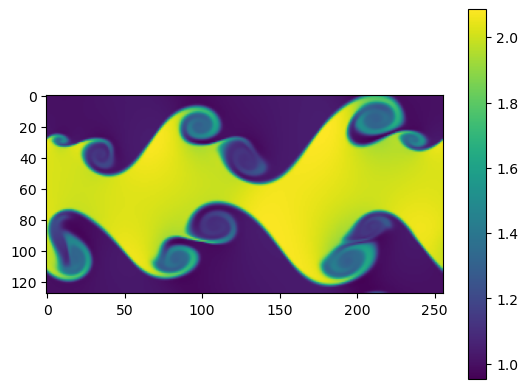

In [14]:
%pylab inline

imshow(q_MOL[0][0])
#imshow(hydrosim.outputs[-1][0][0][-1]-ICs["Etot"][0])#,vmin=-1E-4,vmax=1E-4)
colorbar()
show()

In [15]:
jax.debug.visualize_array_sharding(q_MOL[0][0][:,:,0])


                                                  
                                                  
          GPU 0                    GPU 1          
                                                  
                                                  
                                                  
                                                  
                                                  
          GPU 2                    GPU 3          
                                                  
                                                  
                                                  

In [16]:
from jax.sharding import NamedSharding, PartitionSpec as P

def debug_sharding(x, name="arr"):
    print(f"{name}.sharding:", x.sharding)
    # Each addressable shard should be smaller along the sharded axis
    shards = x.addressable_shards
    print(f"{name} #addressable_shards:", len(shards))
    for s in shards:
        print("  shard index:", s.index, "shape:", s.data.shape, "device:", s.device)

# Example call (inside your with self.mesh: after one pjit_step)
debug_sharding(q_MOL[0], "fields")

fields.sharding: NamedSharding(mesh=Mesh('x': 2, 'y': 2, 'z': 1), spec=PartitionSpec(None, 'x', 'y'), memory_kind=device)
fields #addressable_shards: 4
  shard index: (slice(None, None, None), slice(0, 64, None), slice(0, 128, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:0
  shard index: (slice(None, None, None), slice(0, 64, None), slice(128, 256, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:1
  shard index: (slice(None, None, None), slice(64, 128, None), slice(0, 128, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:2
  shard index: (slice(None, None, None), slice(64, 128, None), slice(128, 256, None), slice(None, None, None)) shape: (5, 64, 128, 1) device: cuda:3


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


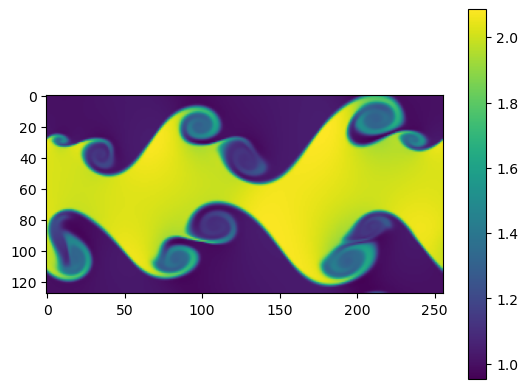

In [17]:
%pylab inline

imshow(q_MOL[0][0])
#imshow(hydrosim.outputs[-1][0][0][-1]-ICs["Etot"][0])#,vmin=-1E-4,vmax=1E-4)
colorbar()
show()

In [18]:
#testing snapshots


hydrosim = dh.hydro(n_super_step=1950*3,fluxes=[cf],use_mol=True,integrator="RK2",pmesh_shape=(2,2,1),snapshot_every=1000)



In [49]:
hydrosim = dh.hydro(n_super_step=10000,fluxes=[cf],use_mol=True,integrator="RK2",pmesh_shape=(2,2,1),snapshot_every=1000)

params = {}
q_MOL = hydrosim.evolve_with_callbacks(sol,params)

In [33]:
out_1 = np.load("./snapshots/fields_step_005000_device_3.npy")

In [50]:
def load_snapshot(hydrosim, step_i, snapshot_dir=None):
    """Load and recombine a full snapshot from individual device shards."""
    import numpy as np
    import os
    
    if snapshot_dir is None:
        snapshot_dir = hydrosim.snapshot_dir
    
    mesh_shape = hydrosim.mesh.shape
    nx, ny, nz = mesh_shape['x'], mesh_shape['y'], mesh_shape['z']
    
    # Load all shards into a dictionary indexed by (x, y, z)
    shards = {}
    for x in range(nx):
        for y in range(ny):
            for z in range(nz):
                linear_idx = x * (ny * nz) + y * nz + z
                path = os.path.join(snapshot_dir, f"fields_step_{step_i:06d}_device_{linear_idx}.npy")
                shards[(x, y, z)] = np.load(path)
    
    # Figure out which field axes correspond to which mesh axes
    # by inspecting FIELD_XYZ
    field_shape = shards[(0, 0, 0)].shape
    partition_spec = hydrosim.FIELD_XYZ
    
    # Map mesh axis names to field dimension indices
    axis_map = {}  # e.g., {'x': 0, 'y': 2} means mesh-x maps to field dim 0, mesh-y to field dim 2
    for field_dim, spec_name in enumerate(partition_spec):
        if spec_name is not None:
            axis_map[spec_name] = field_dim
    
    print(f"Shard shape: {field_shape}")
    print(f"Partition spec: {partition_spec}")
    print(f"Axis mapping: {axis_map}")
    
    # Concatenate along each partitioned axis in order: z, y, x
    result = shards
    
    # Concatenate along z if partitioned
    if nz > 1 and 'z' in axis_map:
        z_axis = axis_map['z']
        new_result = {}
        for x in range(nx):
            for y in range(ny):
                z_parts = [result[(x, y, z)] for z in range(nz)]
                new_result[(x, y)] = np.concatenate(z_parts, axis=z_axis)
        result = new_result
    elif nz == 1:
        # No z partitioning, just drop z index
        result = {(x, y): result[(x, y, 0)] for x in range(nx) for y in range(ny)}
    
    # Concatenate along y if partitioned
    if ny > 1 and 'y' in axis_map:
        y_axis = axis_map['y']
        new_result = {}
        for x in range(nx):
            y_parts = [result[(x, y)] for y in range(ny)]
            new_result[x] = np.concatenate(y_parts, axis=y_axis)
        result = new_result
    elif ny == 1:
        result = {x: result[(x, 0)] for x in range(nx)}
    
    # Concatenate along x if partitioned
    if nx > 1 and 'x' in axis_map:
        x_axis = axis_map['x']
        x_parts = [result[x] for x in range(nx)]
        full_field = np.concatenate(x_parts, axis=x_axis)
    else:
        full_field = result[0]
    
    return full_field

Shard shape: (5, 64, 128, 1)
Partition spec: PartitionSpec(None, 'x', 'y', 'z')
Axis mapping: {'x': 1, 'y': 2, 'z': 3}


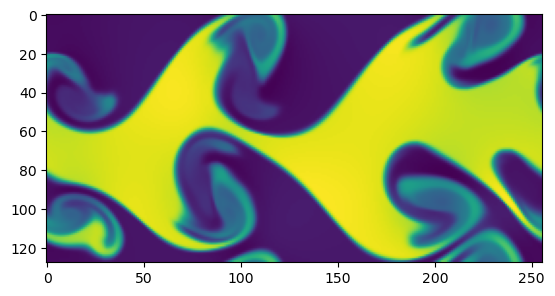

In [56]:
imshow(load_snapshot(hydrosim,7000)[0])

In [62]:
hydrosim = dh.hydro(n_super_step=10000,fluxes=[cf],use_mol=True,integrator="RK2",pmesh_shape=(2,2,1),snapshot_every=1000,maxjit=True)

params = {}

In [58]:
%timeit q_MOL = hydrosim.evolve_with_callbacks(sol,params)

12.6 s ± 664 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%timeit q_MOL_2 = hydrosim.evolve(sol,params)

13.3 s ± 1.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%timeit q_MOL_2 = hydrosim.evolve(sol,params)

13.4 s ± 1.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
q_MOL_2 = hydrosim.evolve(sol,params)

In [68]:
q_MOL = hydrosim.evolve_with_callbacks(sol,params)

In [69]:
hydrosim.sim_time

612.9750366210938

In [61]:
%timeit q_MOL_2 = hydrosim.evolve_old(sol,params)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdac47cc6d0>>
Traceback (most recent call last):
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fdac47cc6d0>>
Traceback (most recent call last):
  File "/home/ben.horowitz/miniconda3/envs/jax-gpu/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
%timeit q_MOL_2 = hydrosim.evolve_old(sol,params)